## Python setup
First, get `pv_model.py` from https://github.com/williamhobbs/pv-system-model (based on [1]) and place it in the same folder as this notebook. 

Then, install pvlib, pandas, and matplotlib, preferably in a virtual environment. I use `conda` via Miniforge (https://github.com/conda-forge/miniforge) to manage environments, but there are a number of different methods you can use. 

I then ran something like this in the Miniforge Prompt:

```
conda create --name pvlib_env python=3.12 -y
conda activate pvlib_env
pip install pvlib matplotlib ipykernel jupyter 
```

[1] Hobbs, W., Anderson, K., Mikofski, M., and Ghiz, M. "An approach to modeling linear and non-linear self-shading losses with pvlib." 2024 PV Performance Modeling Collaborative (PVPMC). https://github.com/williamhobbs/2024_pvpmc_self_shade 


Now, let's import needed packages and functions:

In [1]:
from pv_model import model_pv_power
import matplotlib.pyplot as plt
import pandas as pd
import pvlib

## Model a plant
### Define the plant
Let's define a plant. The function `model_pv_power()` can accept over 30 inputs that defines a number of plant design, operation, and modeling parameters. We will start with a single-axist tracking plant with 1P 72-cell crystalline modules. It will have a ground coverage ratio (GCR) of 0.35, with backtracking enabled and set to a GCR of 0.355 to add a slight buffer, as is typical to account for real-world non-uniformities. We will define the parameters in a dictionary that we can pass to `model_pv_power()` in a bit.

In [2]:
# site location
latitude = 32.8
longitude=  -83.6

plant_data = {
    'latitude': latitude,
    'longitude': longitude,
    'mount_type': 'single-axis',
    'max_tracker_angle': 60,
    'axis_azimuth': 180,
    'axis_tilt': 0,
    'fixed_tilt': None,
    'fixed_azimuth': None,
    'gcr': 0.35,
    'gcr_backtrack_setting': 0.355,
    'nameplate_dc': 1.2,
    'nameplate_ac': 1,
    'cell_type': 'crystalline',
    'gamma_pdc': -0.0035,
    'backtrack': True,
    'bifacial': False,
    'dc_loss_fraction': 0.15,
    'n_cells_up': 12,
    'row_side_num_mods': 1,
    'shade_loss_model': 'non-linear_simple',
    'cross_axis_slope': 0,
    'default_site_transposition_model': 'perez-driesse',
    'slope_aware_backtracking': False,
}

### Resource data
`model_pv_power()` also takes a dataframe of solar resource/weather data for modeling the plant. Let's define a simple clear sky timeseries:

In [3]:
# define times for modeling clear sky solar resource
tz = 'UTC'
freq = '1min'
times = pd.date_range('2020-12-21 12:00', '2020-12-22 0:00', freq=freq, tz=tz)

loc = pvlib.location.Location(latitude,longitude,tz)
solar_position = loc.get_solarposition(times)

# ineichen
cs = loc.get_clearsky(times, model='ineichen')

# add generic temperature, wind, and albedo to have reasonable values
cs['temp_air'] = 10
cs['wind_speed'] = 5
cs['albedo'] = 0.15

### Run the model
Let's pass the resource data, `cs`, and our dictionary of plant data, `plant_data`, to the `model_pv_power()` function. The function returns two variables: a power timeseries and a modified resource data dataframe. We won't need the resource data, so we can write that output variable to `_`, a variable name we won't use. 

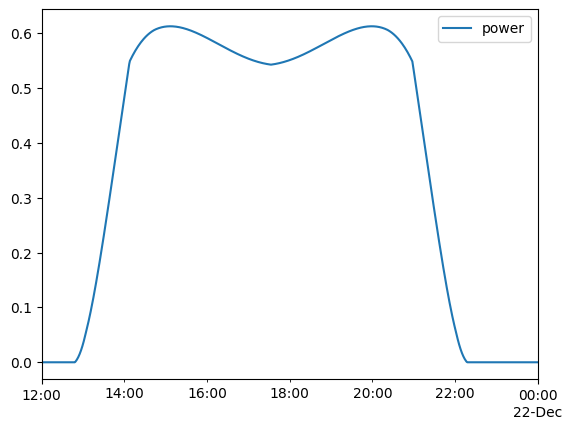

In [4]:
power, _ = model_pv_power(cs,**plant_data)
power.plot(label='power')
plt.legend()
plt.show()

## Cross-axis slope
Not all solar plants are on flat ground with perfectly uniform racking/tracker pile heights. Cross-axis slope is one way to define terrain with slope and/or non-uniform piles.

### Add cross-axis slope
Let's add a cross-axis slope to our plant. Let's start with an aggressive -2.5 degrees. We can create a new dictionary, `plant_data_slope1`, by adding/editing a single key-value pair to `plant_data`.

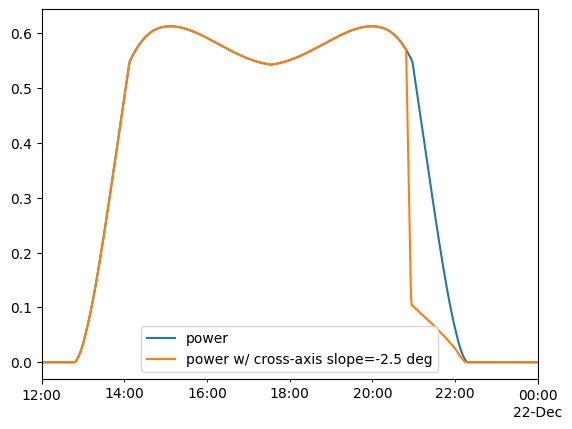

In [5]:
# now, add cross axis slope
plant_data_slope1 = { **plant_data,
                  'cross_axis_slope': -2.5,
                  }
power_slope1, _ = model_pv_power(cs,**plant_data_slope1)

# plot
power.plot(label='power')
power_slope1.plot(label='power w/ cross-axis slope=-2.5 deg')
plt.legend()
plt.show()

We can see the significant impacts of row-to-row self shade in the afternoon due to the cross-axis slope that has not been accounted for in backtracking settings/control.

### Approximating some rolling terrain
You can imagine a plant with gently rolling terrain and similar non-uniformity in tracker pile heights. This situation would not be well represented by a single cross-axis slope; instead, the average of a range of slopes might be a decent approximation. 

We will model three slopes: -2.5, -1.5, and -1.0 degrees, and 

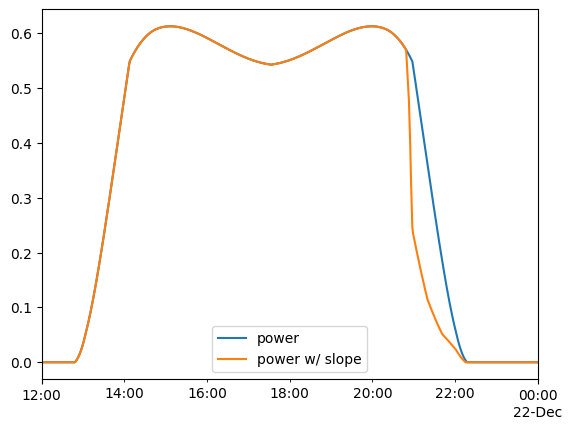

In [6]:
# three configurations
plant_data_slope1 = { **plant_data,
                  'cross_axis_slope': -2.5,
                  }
plant_data_slope2 = { **plant_data,
                  'cross_axis_slope': -1.5,
                  }
plant_data_slope3 = { **plant_data,
                  'cross_axis_slope': -1.0,
                  }

# model power
power_slope1, _ = model_pv_power(cs,**plant_data_slope1)
power_slope2, _ = model_pv_power(cs,**plant_data_slope2)
power_slope3, _ = model_pv_power(cs,**plant_data_slope3)

# calculate the mean
power_mean = pd.concat([power_slope1,
                        power_slope2,
                        power_slope3],
                        axis=1).mean(axis=1)

# plot
power.plot(label='power')
power_mean.plot(label='power w/ slope')
plt.legend()
plt.show()

### Try slope-aware backtracking
Now that we've seen how much impact cross-axis slope can have when backtracking doesn't account for it, let's look at ways to mitigate the shade. A robust way is to use slope-aware backtracking, which is included in `pvlib.tracking.singleaxis`. 

*Note: The demonstration here assumes that backtracking settings can be modified at a very granular level, e.g., at indiividual rows. If that was not a good assumption, we could more manually calculate the tracker rotation angles for the steepest cross-axis slope in the array (using `pvlib.tracking.singleaxis`) and then model each subset of the plant (with the different slopes) using the same rotation angles. `model_pv_power()` can accept series/dataframe inputs for `surface_azimuth_timeseries` and `surface_tilt_timeseries` and use those to model the trackers.* 

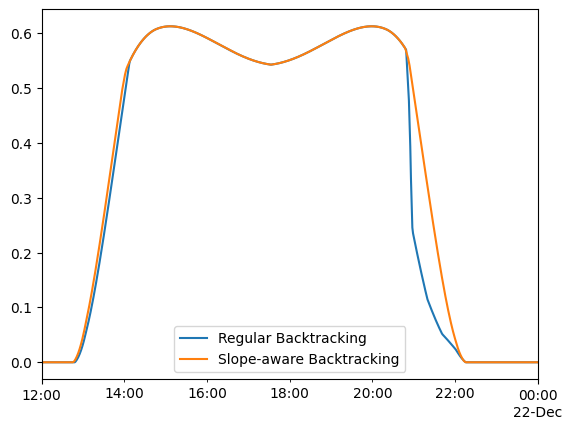

In [7]:
plant_data_slope1_sabt = { **plant_data,
                  'cross_axis_slope': -2.5,
                  'slope_aware_backtracking': True,
                  }
plant_data_slope2_sabt = { **plant_data,
                  'cross_axis_slope': -1.5,
                  'slope_aware_backtracking': True,
                  }
plant_data_slope3_sabt = { **plant_data,
                  'cross_axis_slope': -1.0,
                  'slope_aware_backtracking': True,
                  }

power_slope1_sabt, _ = model_pv_power(cs,**plant_data_slope1_sabt)
power_slope2_sabt, _ = model_pv_power(cs,**plant_data_slope2_sabt)
power_slope3_sabt, _ = model_pv_power(cs,**plant_data_slope3_sabt)

power_mean_sabt = pd.concat([power_slope1_sabt,
                             power_slope2_sabt,
                             power_slope3_sabt],
                             axis=1).mean(axis=1)

# plot
power_mean.plot(label='Regular Backtracking')
power_mean_sabt.plot(label='Slope-aware Backtracking')
plt.legend()
plt.show()

### Compare with East/West (or morning/afternoon, AM/PM) backtracking settings
Some tracker controllers allow for unique East/West row spacing/GCR inputs. This can be used to help mitigate cross-axis slope issues. We will vary the AM and PM GCR values. These were manually psuedo-optimized for each cross-axis slope, but a more robust search or optimization could be performed, possibly with modest improvements. 

*Note: Similar to the previous note, backtracking settings here vary with slope. For uniform settings/control, the highest AM and PM GCR values needed for any given slope could be used for the whole array.*

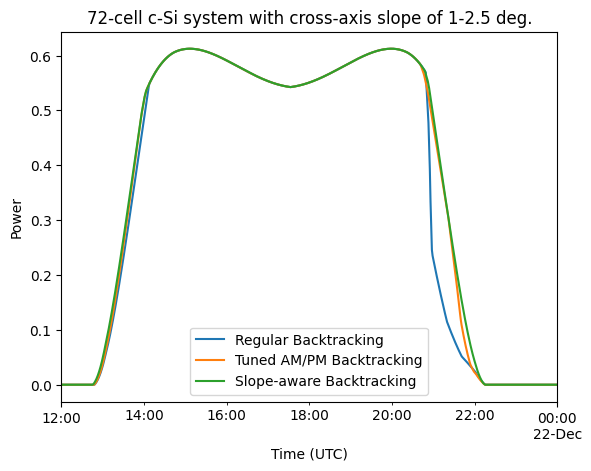

In [8]:
plant_data_slope1_ampm = { **plant_data,
                          'cross_axis_slope': -2.5,
                          'programmed_gcr_am': 0.31,
                          'programmed_gcr_pm': 0.42,
                          }
plant_data_slope2_ampm = { **plant_data,
                          'cross_axis_slope': -1.5,
                          'programmed_gcr_am': 0.33,
                          'programmed_gcr_pm': 0.40,
                          }
plant_data_slope3_ampm = { **plant_data,
                          'cross_axis_slope': -1.0,
                          'programmed_gcr_am': 0.34,
                          'programmed_gcr_pm': 0.38,
                          }

power_slope1_ampm, _ = model_pv_power(cs,**plant_data_slope1_ampm)
power_slope2_ampm, _ = model_pv_power(cs,**plant_data_slope2_ampm)
power_slope3_ampm, _ = model_pv_power(cs,**plant_data_slope3_ampm)

power_mean_ampm = pd.concat([power_slope1_ampm,
                             power_slope2_ampm,
                             power_slope3_ampm],
                             axis=1).mean(axis=1)

power_mean.plot(label='Regular Backtracking')
power_mean_ampm.plot(label='Tuned AM/PM Backtracking')
power_mean_sabt.plot(label='Slope-aware Backtracking')
plt.title('72-cell c-Si system with cross-axis slope of 1-2.5 deg.')
plt.xlabel('Time (UTC)')
plt.ylabel('Power')
plt.legend()
# plt.savefig('model_sample.png', dpi=400, bbox_inches='tight')
plt.show()

We can see that slope-aware backtracking has a slight gain over the independently tuned AM/PM GCR backtracking settings. Let's look at the percentage differences:

In [9]:
# gain relative to regular backtracking
ampm_gain = (power_mean_ampm.sum() - power_mean.sum())/power_mean.sum()
sabt_gain = (power_mean_sabt.sum() - power_mean.sum())/power_mean.sum()

print('AM/PM gain:       ' + "{:.2f}".format(ampm_gain*100) + '%')
print('Slope-aware gain: ' + "{:.2f}".format(sabt_gain*100) + '%')

AM/PM gain:       3.95%
Slope-aware gain: 4.85%


We can see that both versions of updated backtracking control have a significant improvement. Slope-aware backtracking is almost 1 percentage-point higher, but either could make a meaningful impact on plant production. 

*Note: this is just a single clear sky winter day, which is close to a "worst case" for self-shade. This analysis could be expanded by using, e.g., NSRDB data to represent a whole year for a plant of interest.*

## Tracker position offset
Due to calibration or installation issues, it is possible for a tracker's actual rotation angle to be offset from the angle that the controller thinks it is at, resulting in trackers pointed at the wrong angle. 

Let's manually model tracker angles for our plant, keeping cross-axis tilt at zero for this example:

In [10]:
tr = pvlib.tracking.singleaxis(
    apparent_zenith=solar_position.apparent_zenith,
    apparent_azimuth=solar_position.azimuth,
    axis_tilt=plant_data['axis_tilt'],
    axis_azimuth=plant_data['axis_azimuth'],
    max_angle=plant_data['max_tracker_angle'],
    gcr=plant_data['gcr_backtrack_setting'],
    cross_axis_tilt=0)

One of the outputs is tracker rotation angle, theta. Let's calculate a new tracker theta based on a fixed offset.

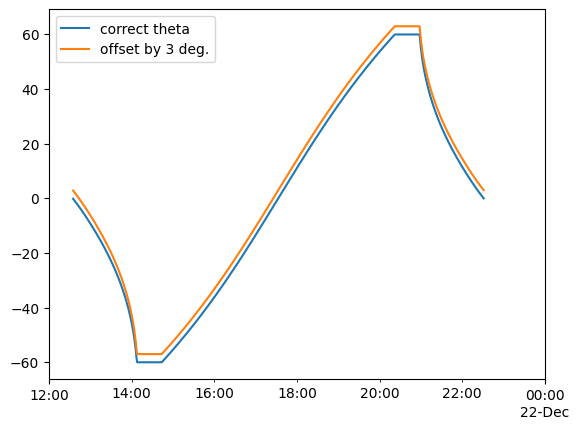

In [11]:
offset = 3 # degrees
tracker_theta_offset = tr['tracker_theta'] + offset
tr['tracker_theta'].plot(label='correct theta')
tracker_theta_offset.plot(label=('offset by ' + str(offset) + ' deg.'))
plt.legend()
plt.show()

Now, we need to calculate the resulting surface azimuth and tilt for the offset tracker. 

In [12]:
tr_offset = pvlib.tracking.calc_surface_orientation(
    tracker_theta=tracker_theta_offset,
    axis_tilt=plant_data['axis_tilt'],
    axis_azimuth=plant_data['axis_azimuth'],
)

tr_offset.head()

,surface_tilt,surface_azimuth
2020-12-21 12:00:00+00:00,NaN,NaN
2020-12-21 12:01:00+00:00,NaN,NaN
2020-12-21 12:02:00+00:00,NaN,NaN
2020-12-21 12:03:00+00:00,NaN,NaN
2020-12-21 12:04:00+00:00,NaN,NaN


Update the plant data with the new offset tracker timeseries:

In [13]:
plant_data_offset = {
    **plant_data,
    'surface_tilt_timeseries': tr_offset['surface_tilt'],
    'surface_azimuth_timeseries': tr_offset['surface_azimuth'],
    'tracker_theta_timeseries': tracker_theta_offset,
}

And make a plot:

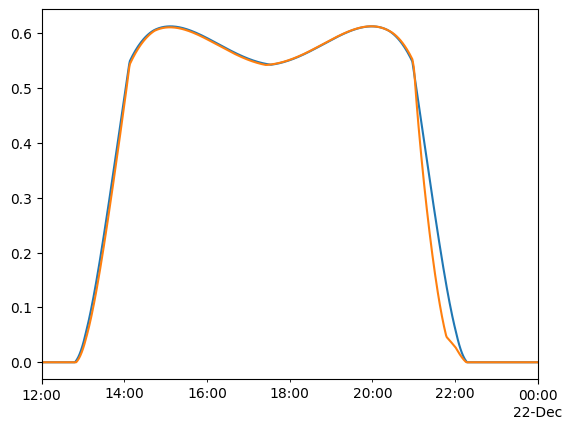

In [14]:
power_offset, _ = model_pv_power(cs,**plant_data_offset)
power.plot(label='correct')
power_offset.plot(label=('offset by ' + str(offset) + ' deg.'))
plt.show()

You can see that in the morning and throughout the middle of the day, a 3 degree offset only has a small impact, but the resulting self-shade in the afternoon is much more significant.

## Ideas for additional analysis
Other non-idealites could also be explored with this toolset, like:
- tracker clock drift (see [1] for an example)
- discontinuous tracking (see the pvlib documentation example gallery) with self-shade caused by cross-axis slope and/or incorrect GCR settings, which can result in a sawtooth power profile.
- fixed-tilt systems with "cross-axis" slope (*note that the "axis" in this case is perpendictular to the rows, therefore more likely to run North-South for fixed tilt, as opposed to East-West for single axis trackers*)

[1] Hobbs, W., Anderson, K., Mikofski, M., and Ghiz, M. "An approach to modeling linear and non-linear self-shading losses with pvlib." 2024 PV Performance Modeling Collaborative (PVPMC). https://github.com/williamhobbs/2024_pvpmc_self_shade 